# Jupyter Notebook Summary

This Jupyter Notebook performs curve fitting of transription noise vs mean level using FACS and PCR data.
To run it, you will need a python environment (created e.g. with conda, pyenv or venv) with the packages from requirements.txt installed. 

Below is a summary of the notebook contents:

1. **Import required modules**
    - Modules such as `os`, `numpy`, `pandas`, `matplotlib`, `seaborn`, `scipy`, and `sklearn` are imported.

2. **Define functions**
    - `reciprocal_cv_mean(mean, const)`: Reciprocal model function.
    - `reciprocal_cv_mean_with_intercept(mean, const, intercept)`: Reciprocal model with intercept function.
    - `exponential_decay_cv_mean(mean, scale, const, intercept)`: Exponential decay model function.
    - `_fit_to_empirical_model(xdata: np.ndarray, ydata: np.ndarray, model, bounds)`: Fits data to an empirical model using `curve_fit`.
    - `draw_plot_with_fit(data: pd.DataFrame, x: str, y: str, key: str, level: str, func_dict: dict, model: str, name: str, legend: str = None, ax_lims: tuple[tuple, tuple] = None, title: str = None, x_label: str = None, y_label: str = None, palette: dict = None) -> tuple[np.ndarray, np.ndarray, float, float]`: Draws a scatter plot with fitted curve and saves it as SVG file.
    - `_draw_plot_with_fit_in_multiplot(fig: plt.Figure, ax: plt.Axes, data: pd.DataFrame, x: str, y: str, key: str, level: str, func_dict: dict, model: str, legend: str = None, ax_lims: tuple[tuple, tuple] = None, title: str = None, x_label: str = None, y_label: str = None, palette: dict = None) -> None`: Creates a scatter plot with fitted curve on a specified matplotlib subplot.
    - `draw_multiplot_grid(m: int, n: int, args_list: list, save_path: str = None) -> None`: Creates a grid of subplots with fitted curves and scatter plots.

3. **Define source file and load data frames**
    - `source_df`: Data frame with FACS data for 33 clones and 11 timepoints, as well as clone 814 after sorting.
    - `PCR_df`: Data frame with FACS and PCR data for 8 clones and 6 timepoints.
    - `GROUP_COLORS`: Colors for each group of clones.
    - `CLONE_BY_GROUP_COLORS`: Colors for each clone based on groups.

4. **Perform fitting and visualisation**



1. Import modules

In [1]:
import pathlib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

2. Define functions

In [2]:
# Define curve-fitting models and collect them into a dictionary
func_dict = {}


def reciprocal_cv_mean(mean, const):
    return const / mean


func_dict["reciprocal"] = (reciprocal_cv_mean, (-np.inf, np.inf))


def reciprocal_cv_mean_with_intercept(mean, const, intercept):
    return const / mean + intercept


func_dict["reciprocal_with_intercept"] = (
    reciprocal_cv_mean_with_intercept,
    (0, np.inf),
)


def exponential_decay_cv_mean(mean, scale, const, intercept):
    return scale * np.exp(-const * mean) + intercept


func_dict["exponential"] = (exponential_decay_cv_mean, (0, np.inf))


def _fit_to_empirical_model(xdata: np.ndarray, ydata: np.ndarray, model, bounds):
    """
    Fits data to an empirical model using curve_fit from scipy.

    Args:
        xdata (np.ndarray): Independent variable data points.
        ydata (np.ndarray): Dependent variable data points.
        model: Function defining the model to fit.
        bounds: Parameter bounds for the fitting.

    Returns:
        tuple: Contains:
            - popt (np.ndarray): Optimal parameters from the fit
            - perr (np.ndarray): Standard errors of the parameters
            - pcv (np.ndarray): Coefficient of variation for parameters.
    """
    popt, pcov = curve_fit(f=model, xdata=xdata, ydata=ydata, bounds=bounds)

    perr = np.sqrt(np.diag(pcov))
    pcv = perr / popt

    return popt, perr, pcv


def draw_plot_with_fit(
    data: pd.DataFrame,
    x: str,
    y: str,
    key: str,
    level: str,
    func_dict: dict,
    model: str,
    name: str,
    legend: str = None,
    ax_lims: tuple[tuple, tuple] = None,
    title: str = None,
    x_label: str = None,
    y_label: str = None,
    palette: dict = None,
) -> tuple[np.ndarray, np.ndarray, float, float]:
    """
    Draws a scatter plot with fitted curve and saves it as SVG file.

    Args:
        data (pd.DataFrame): Input data frame.
        x (str): Column name for x-axis data.
        y (str): Column name for y-axis data.
        key (str): Key for data selection, use 'all' for entire dataset.
        level (str): Multiindex level name for data selection.
        func_dict (dict): Dictionary of fitting functions and their bounds.
        model (str): Model name to select from func_dict.
        name (str): Name for output file.
        legend (str, optional): Column name for plot legend. Defaults to None.
        ax_lims (tuple[tuple, tuple], optional): Axis limits ((xmin,xmax), (ymin,ymax)). Defaults to None.
        title (str, optional): Plot title. Defaults to None.
        x_label (str, optional): X-axis label. Defaults to None.
        y_label (str, optional): Y-axis label. Defaults to None.
        palette (dict, optional): Palette to be used by scatter plot. Defaults to None.

    Returns:
        tuple[np.ndarray, np.ndarray, float, float]: Optimal parameters, parameter errors,
            parameter coefficient of variation, and R-squared value.
    """
    if key == "all":
        partial_df = data
    else:
        partial_df = data.xs(key=key, level=level)
    xdata = partial_df[x]
    ydata = partial_df[y]
    chosen_model = func_dict[model][0]
    bounds = func_dict[model][1]
    try:
        popt, perr, pcv = _fit_to_empirical_model(
            xdata, ydata, chosen_model, bounds=bounds
        )
    except RuntimeError:
        return ([], [], 0, np.nan)
    y_hat = [chosen_model(x, *popt) for x in xdata]
    try:
        r2 = r2_score(ydata, y_hat)
    except ValueError:
        r2 = np.nan

    if palette == None:
        palette = "Dark2"

    fitx = np.linspace(min(xdata), max(xdata), 100)
    fity = [chosen_model(x, *popt) for x in fitx]
    fig, ax = plt.subplots()
    sns.scatterplot(data=partial_df, x=xdata, y=ydata, hue=legend, palette=palette)
    sns.lineplot(x=fitx, y=fity)
    plt.text(0.8, 0.8, f"R2 = {round(r2,2)}", transform=plt.gca().transAxes)
    ax.set_title(f"{name}, {model}")
    if not legend:
        ax.get_legend().remove()
    if ax_lims:
        ax.set_xlim(ax_lims[0])
        ax.set_ylim(ax_lims[1])
    if title:
        ax.set_title(title)
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)
    plt.savefig(f"output/facs_curve_fit/{model}/{name}.svg", format="svg", dpi=300)
    return popt, perr, pcv, r2


def _draw_plot_with_fit_in_multiplot(
    fig: plt.Figure,
    ax: plt.Axes,
    data: pd.DataFrame,
    x: str,
    y: str,
    key: str,
    level: str,
    func_dict: dict,
    model: str,
    legend: str = None,
    ax_lims: tuple[tuple, tuple] = None,
    title: str = None,
    x_label: str = None,
    y_label: str = None,
    palette: dict = None,
) -> None:
    """
    Creates a scatter plot with fitted curve on a specified matplotlib subplot.

    Args:
        fig (plt.Figure): Matplotlib figure object containing the subplot.
        ax (plt.Axes): Matplotlib axes object for plotting.
        data (pd.DataFrame): Input data frame.
        x (str): Column name for x-axis data.
        y (str): Column name for y-axis data.
        key (str): Key for data selection, use 'all' for entire dataset.
        level (str): Multiindex level name for data selection.
        func_dict (dict): Dictionary of fitting functions and their bounds.
        model (str): Model name to select from func_dict.
        legend (str, optional): Column name for plot legend. Defaults to None.
        ax_lims (tuple[tuple, tuple], optional): Axis limits ((xmin,xmax), (ymin,ymax)). Defaults to None.
        title (str, optional): Plot title. Defaults to None.
        x_label (str, optional): X-axis label. Defaults to None.
        y_label (str, optional): Y-axis label. Defaults to None.
        palette (dict, optional): Palette to be used by scatter plot. Defaults to None.

    Returns:
        None
    """
    if key == "all":
        partial_df = data
    else:
        partial_df = data.xs(key=key, level=level)
    xdata = partial_df[x]
    ydata = partial_df[y]
    chosen_model = func_dict[model][0]
    bounds = func_dict[model][1]
    try:
        popt, _, _ = _fit_to_empirical_model(xdata, ydata, chosen_model, bounds=bounds)
    except RuntimeError:
        return ([], [], 0)
    y_hat = [chosen_model(x, *popt) for x in xdata]
    try:
        r2 = r2_score(ydata, y_hat)
    except ValueError:
        r2 = np.nan

    if palette == None:
        palette = "Dark2"
    fitx = np.linspace(min(xdata), max(xdata), 100)
    fity = [chosen_model(x, *popt) for x in fitx]
    sns.scatterplot(
        ax=ax, data=partial_df, x=xdata, y=ydata, hue=legend, palette=palette
    )
    sns.lineplot(ax=ax, x=fitx, y=fity)
    plt.text(x=0.5, y=0.8, s=f"R2 = {round(r2,2)}", transform=ax.transAxes)

    if not legend:
        ax.get_legend().remove()
    if ax_lims:
        ax.set_xlim(ax_lims[0])
        ax.set_ylim(ax_lims[1])
    if title:
        ax.set_title(title)
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)


def draw_multiplot_grid(m: int, n: int, args_list: list, save_path: str = None) -> None:
    """
    Creates a grid of subplots with fitted curves and scatter plots.

    Args:
        m (int): Number of rows in the grid.
        n (int): Number of columns in the grid.
        args_list (list): List of dictionaries containing arguments for _draw_plot_with_fit_in_multiplot
                         Each dictionary should contain all required parameters for a single subplot.
        save_path (str, optional): Path to save the figure as SVG file. Defaults to None.

    Returns:
        None

    The function creates a figure with m×n subplots, where each subplot is created using
    _draw_plot_with_fit_in_multiplot with the corresponding arguments from args_list.
    The figure size is automatically set to (n*6, m*6) inches with adjusted spacing
    between subplots.
    """
    fig, axes = plt.subplots(m, n, figsize=(n * 6, m * 6))
    plt.subplots_adjust(hspace=0.25, wspace=0.25)
    for i, args in enumerate(args_list):
        if len(axes.shape) == 1:
            _draw_plot_with_fit_in_multiplot(fig=fig, ax=axes[i], **args)
        else:
            _draw_plot_with_fit_in_multiplot(fig=fig, ax=axes[i // n, i % n], **args)
    if save_path:
        plt.savefig(save_path, format="svg", dpi=300)

3. Define source files and load data frames

In [3]:
# This data frame has flow cytometry results for 33 clones from 11 timepoints, as used in Figure 4C.
source_df = pd.read_csv("input/SuppTable1.txt", sep="\t", index_col=("Clone", "Date"))
source_df.index = source_df.index.set_levels(
    [source_df.index.levels[0].astype(str), source_df.index.levels[1].astype(str)]
)

# This data frame has flow cytometry results for unsorted clone 814 from the same 11 timepoints, as used in Figure 4C.
Fsorted_df = pd.read_csv("input/SuppTable3.txt", sep="\t", index_col=("Clone", "Date"))
Fsorted_df.index = Fsorted_df.index.set_levels(
    [Fsorted_df.index.levels[0].astype(str), Fsorted_df.index.levels[1].astype(str)]
)

# Concatenate all flow cytometry results into one data frame.
source_df = pd.concat([source_df, Fsorted_df])

# This data frames has both flow cytometry and qPCR results for 8 clones at 6 timepoints, as used in Figure 4G.
PCR_df = pd.read_csv("input/SuppTable2.txt", sep="\t", index_col=("Clone", "Date"))
PCR_df.index = PCR_df.index.set_levels(
    [PCR_df.index.levels[0].astype(str), PCR_df.index.levels[1].astype(str)]
)

# Scale mean fluorescence to kAU, calculate CV-squared from CV. Also converts CV from percentages to ratios.
for df in [source_df, PCR_df]:
    df["Mean.live_scaled"] = df["Mean.live"] / 1000
    df["CV2.live"] = (df["CV.live"] / 100) ** 2

# Create group color palette.
GROUP_COLORS = {
    "S": "black",
    "A-": "orange",
    "A": "red",
    "F": "green",
    "F_neg": "grey",
    "F_pos": "green",
}

# Create clone color palette from GROUP_PALETTE based on group membership.
CLONE_BY_GROUP_COLORS = {}

# Add colors for clones from source_df based on their group.
for clone, group in source_df["Group"].groupby("Clone").first().items():
    CLONE_BY_GROUP_COLORS[clone] = GROUP_COLORS[group]

4. Fit data to reciprocal model as conceptualized in Singh et al. 2010.
Fig. 4B

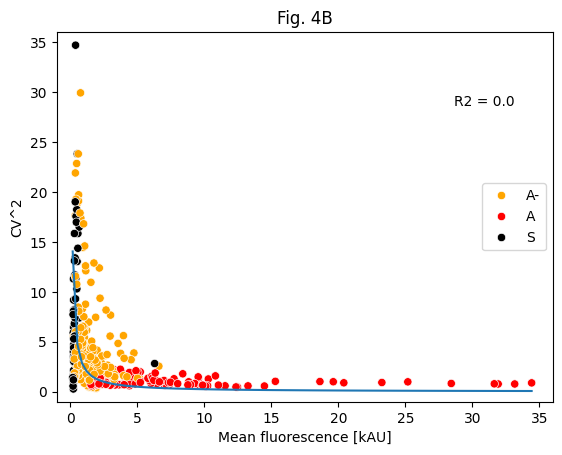

In [4]:
clones_wo_814 = source_df.index.levels[0].unique().drop(["814", "814_neg", "814_pos"])
results = {"params": [], "err": [], "cv": [], "r2": []}
if not pathlib.Path(f"output/facs_curve_fit/reciprocal/").exists():
    os.makedirs(f"output/facs_curve_fit/reciprocal/")
popt, perr, pcv, r2 = draw_plot_with_fit(
    source_df.loc[clones_wo_814],
    "Mean.live_scaled",
    "CV2.live",
    key="all",
    level=None,
    func_dict=func_dict,
    model="reciprocal",
    name="fig4b",
    legend="Group",
    ax_lims=((-1, 36), (-1, 36)),
    title="Fig. 4B",
    x_label="Mean fluorescence [kAU]",
    y_label="CV^2",
    palette=GROUP_COLORS,
)
results["params"].append(popt)
results["err"].append(perr)
results["cv"].append(pcv)
results["r2"].append(r2)

5. Fit to newly proposed exponential model

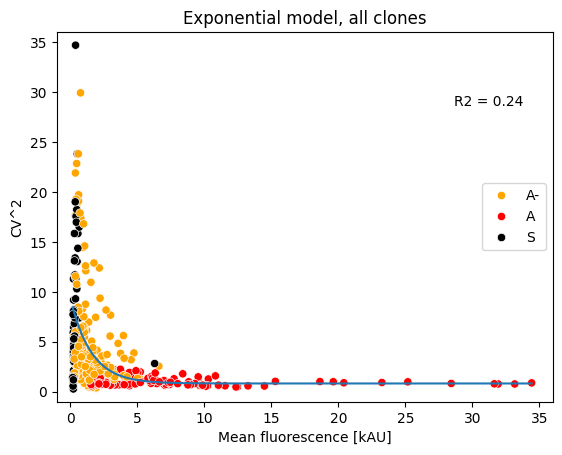

In [5]:
results = {"params": [], "err": [], "cv": [], "r2": []}
if not pathlib.Path(f"output/facs_curve_fit/exponential/").exists():
    os.makedirs(f"output/facs_curve_fit/exponential/")
popt, perr, pcv, r2 = draw_plot_with_fit(
    source_df.loc[clones_wo_814],
    "Mean.live_scaled",
    "CV2.live",
    key="all",
    level=None,
    func_dict=func_dict,
    model="exponential",
    name="exp_all",
    legend="Group",
    ax_lims=((-1, 36), (-1, 36)),
    title="Exponential model, all clones",
    x_label="Mean fluorescence [kAU]",
    y_label="CV^2",
    palette=GROUP_COLORS,
)
results["params"].append(popt)
results["err"].append(perr)
results["cv"].append(pcv)
results["r2"].append(r2)

6. Remove S group clones from data and re-fit. Fig. 4C.

In [6]:
S_df = source_df[source_df["Group"] == "S"]
F_df = source_df[source_df["Group"].str.contains("F")]
noS_df = source_df.loc[
    (source_df["Group"] != "S") & (~source_df["Group"].str.contains("F"))
]

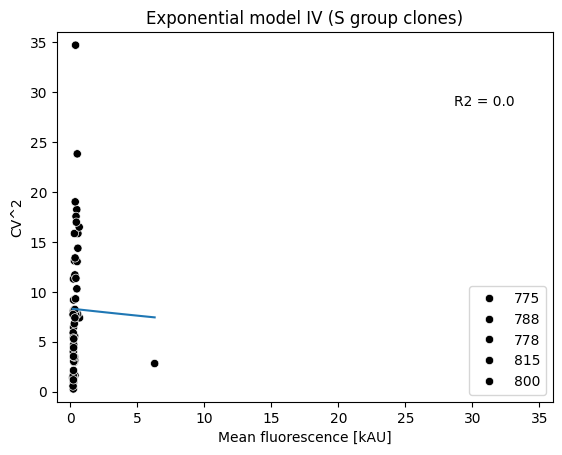

In [7]:
results = {"params": [], "err": [], "cv": [], "r2": []}
if not pathlib.Path(f"output/facs_curve_fit/exponential/").exists():
    os.makedirs(f"output/facs_curve_fit/exponential/")
popt, perr, pcv, r2 = draw_plot_with_fit(
    S_df,
    "Mean.live_scaled",
    "CV2.live",
    key="all",
    level=None,
    func_dict=func_dict,
    model="exponential",
    name="fig4c_modelIV",
    legend="Clone",
    ax_lims=((-1, 36), (-1, 36)),
    title="Exponential model IV (S group clones)",
    x_label="Mean fluorescence [kAU]",
    y_label="CV^2",
    palette=CLONE_BY_GROUP_COLORS,
)
results["params"].append(popt)
results["err"].append(perr)
results["cv"].append(pcv)
results["r2"].append(r2)
modelIV_params = popt
modelIV_errors = perr
modelIV_r2 = r2

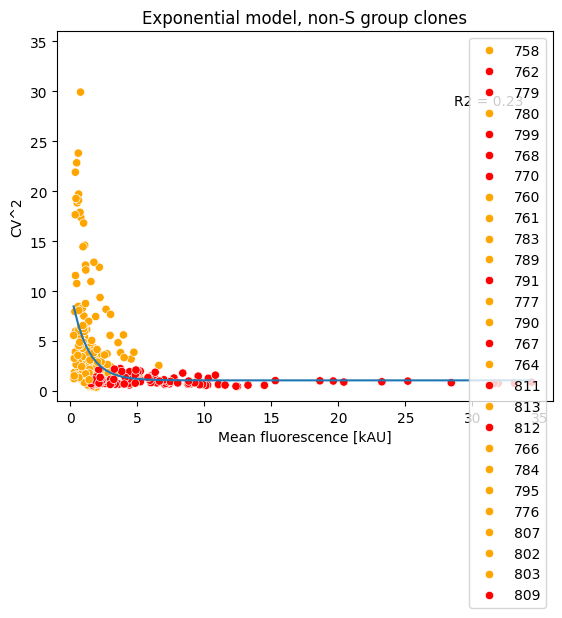

In [8]:
results = {"params": [], "err": [], "cv": [], "r2": []}
if not pathlib.Path(f"output/facs_curve_fit/exponential/").exists():
    os.makedirs(f"output/facs_curve_fit/exponential/")
popt, perr, pcv, r2 = draw_plot_with_fit(
    noS_df,
    "Mean.live_scaled",
    "CV2.live",
    key="all",
    level=None,
    func_dict=func_dict,
    model="exponential",
    name="exp_nons",
    legend="Clone",
    ax_lims=((-1, 36), (-1, 36)),
    title="Exponential model, non-S group clones",
    x_label="Mean fluorescence [kAU]",
    y_label="CV^2",
    palette=CLONE_BY_GROUP_COLORS,
)
results["params"].append(popt)
results["err"].append(perr)
results["cv"].append(pcv)
results["r2"].append(r2)
scale = popt[0]
const = popt[1]
intercept = popt[2]
params = scale, const, intercept

7. Identify outliers based on sum of square errors and R-squared

/tmp/ipykernel_729964/2445074544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noS_df["CV2.live_pred"] = noS_df["Mean.live_scaled"].apply(
/tmp/ipykernel_729964/2445074544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noS_df["square_residues"] = (noS_df["CV2.live_pred"] - noS_df["CV2.live"]) ** 2


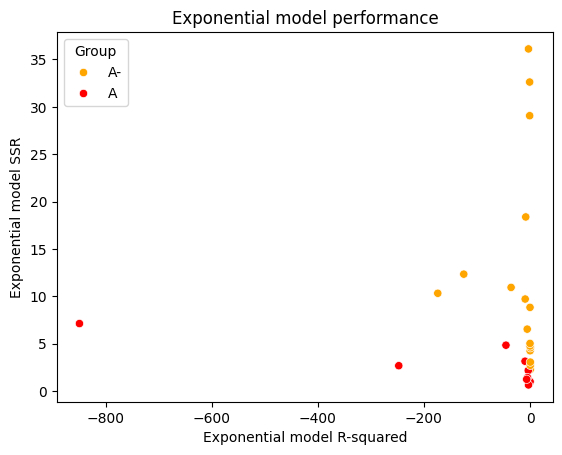

In [9]:
noS_df["CV2.live_pred"] = noS_df["Mean.live_scaled"].apply(
    lambda mean: exponential_decay_cv_mean(mean, scale, const, intercept)
)
noS_df["square_residues"] = (noS_df["CV2.live_pred"] - noS_df["CV2.live"]) ** 2
SSRs = np.sqrt(noS_df["square_residues"].groupby("Clone").sum())
R2s = noS_df.groupby("Clone").apply(
    lambda clone: r2_score(clone["CV2.live"], clone["CV2.live_pred"])
)
R2s.name = "R-squared"
fig, ax = plt.subplots()
sns.scatterplot(
    x=R2s, y=SSRs, hue=noS_df["Group"].groupby("Clone").first(), palette=GROUP_COLORS
)
ax.set_xlabel("Exponential model R-squared")
ax.set_ylabel("Exponential model SSR")
ax.set_title("Exponential model performance")
plt.savefig(f"output/facs_curve_fit/exponential_performance.svg", format="svg", dpi=300)

8. Fit model to main group clones and high and low noise outilers separately. Fig. 4C.

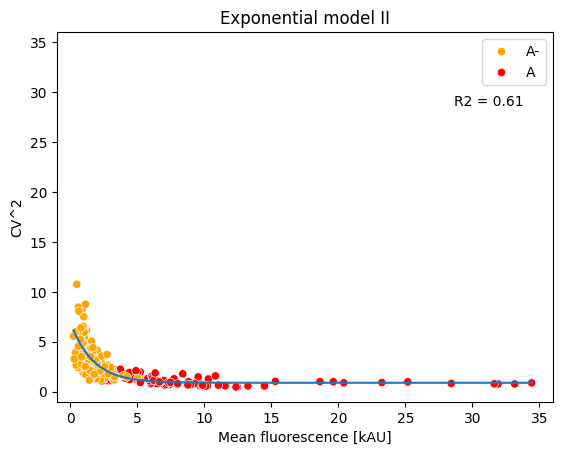

In [10]:
modelII_clones = R2s[R2s > -25].index.intersection(SSRs[SSRs < 15].index)
results = {"params": [], "err": [], "cv": [], "r2": []}
if not pathlib.Path(f"output/facs_curve_fit/exponential/").exists():
    os.makedirs(f"output/facs_curve_fit/exponential/")
popt, perr, pcv, r2 = draw_plot_with_fit(
    noS_df.loc[modelII_clones],
    "Mean.live_scaled",
    "CV2.live",
    key="all",
    level=None,
    func_dict=func_dict,
    model="exponential",
    name="fig4c_modelII",
    legend="Group",
    ax_lims=((-1, 36), (-1, 36)),
    title="Exponential model II",
    x_label="Mean fluorescence [kAU]",
    y_label="CV^2",
    palette=GROUP_COLORS,
)
results["params"].append(popt)
results["err"].append(perr)
results["cv"].append(pcv)
results["r2"].append(r2)
modelII_params = popt
modelII_errors = perr
modelII_r2 = r2

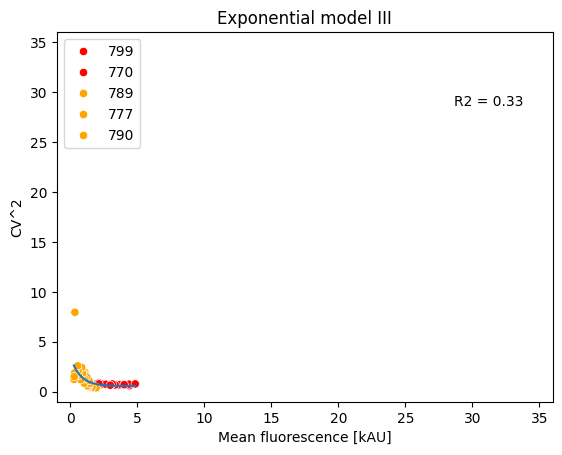

In [11]:
modelIII_clones = ["799", "770", "789", "777", "790"]
results = {"params": [], "err": [], "cv": [], "r2": []}
if not pathlib.Path(f"output/facs_curve_fit/exponential/").exists():
    os.makedirs(f"output/facs_curve_fit/exponential/")
popt, perr, pcv, r2 = draw_plot_with_fit(
    noS_df.loc[modelIII_clones],
    "Mean.live_scaled",
    "CV2.live",
    key="all",
    level=None,
    func_dict=func_dict,
    model="exponential",
    name="fig4c_modelIII",
    legend="Clone",
    ax_lims=((-1, 36), (-1, 36)),
    title="Exponential model III",
    x_label="Mean fluorescence [kAU]",
    y_label="CV^2",
    palette=CLONE_BY_GROUP_COLORS,
)
results["params"].append(popt)
results["err"].append(perr)
results["cv"].append(pcv)
results["r2"].append(r2)
modelIII_params = popt
modelIII_errors = perr
modelIII_r2 = r2

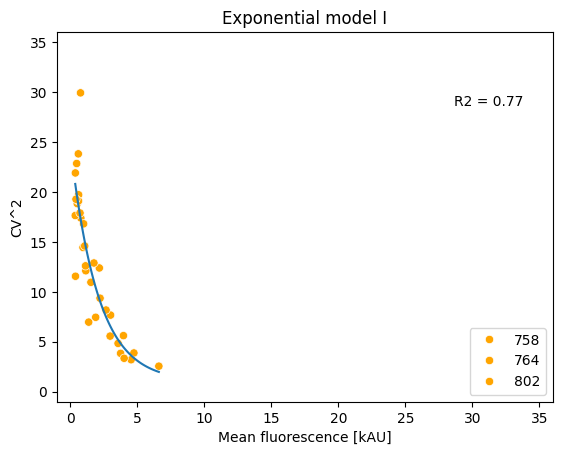

In [12]:
modelI_clones = SSRs[SSRs > 20].index
results = {"params": [], "err": [], "cv": [], "r2": []}
if not pathlib.Path(f"output/facs_curve_fit/exponential/").exists():
    os.makedirs(f"output/facs_curve_fit/exponential/")
popt, perr, pcv, r2 = draw_plot_with_fit(
    noS_df.loc[modelI_clones],
    "Mean.live_scaled",
    "CV2.live",
    key="all",
    level=None,
    func_dict=func_dict,
    model="exponential",
    name="fig4c_modelI",
    legend="Clone",
    ax_lims=((-1, 36), (-1, 36)),
    title="Exponential model I",
    x_label="Mean fluorescence [kAU]",
    y_label="CV^2",
    palette=CLONE_BY_GROUP_COLORS,
)
results["params"].append(popt)
results["err"].append(perr)
results["cv"].append(pcv)
results["r2"].append(r2)
modelI_params = popt
modelI_errors = perr
modelI_r2 = r2

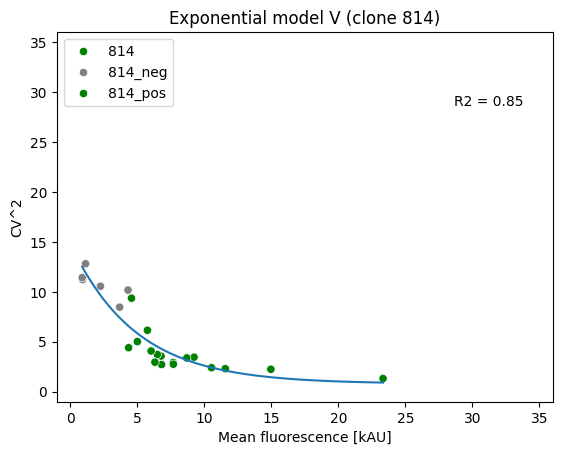

In [13]:
results = {"params": [], "err": [], "cv": [], "r2": []}
if not pathlib.Path(f"output/facs_curve_fit/exponential/").exists():
    os.makedirs(f"output/facs_curve_fit/exponential/")
popt, perr, pcv, r2 = draw_plot_with_fit(
    F_df,
    "Mean.live_scaled",
    "CV2.live",
    key="all",
    level=None,
    func_dict=func_dict,
    model="exponential",
    name="fig4c_modelV",
    legend="Clone",
    ax_lims=((-1, 36), (-1, 36)),
    title="Exponential model V (clone 814)",
    x_label="Mean fluorescence [kAU]",
    y_label="CV^2",
    palette=CLONE_BY_GROUP_COLORS,
)
results["params"].append(popt)
results["err"].append(perr)
results["cv"].append(pcv)
results["r2"].append(r2)
modelV_params = popt
modelV_errors = perr
modelV_r2 = r2

9. Comparison of fitted models. Fig. 4C.

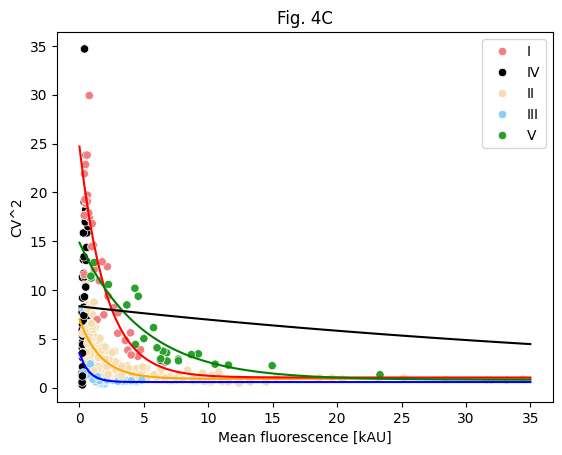

In [14]:
source_df["Model"] = "II"
source_df.loc[modelI_clones, "Model"] = "I"
source_df.loc[modelIII_clones, "Model"] = "III"
source_df.loc[source_df["Group"] == "S", "Model"] = "IV"
source_df.loc[source_df["Group"].str.contains("F"), "Model"] = "V"

MODEL_COLORS = {
    "IV": "black",
    "III": "lightskyblue",
    "II": "wheat",
    "I": "lightcoral",
    "V": "tab:green",
}
CLONE_BY_MODEL_COLORS = {}
for clone, model in source_df["Model"].groupby("Clone").first().items():
    CLONE_BY_MODEL_COLORS[clone] = MODEL_COLORS[model]
fig, ax = plt.subplots()
fitx = np.linspace(0, 35, 100)
fity_main = [func_dict["exponential"][0](x, *modelII_params) for x in fitx]
fity_high = [func_dict["exponential"][0](x, *modelI_params) for x in fitx]
fity_low = [func_dict["exponential"][0](x, *modelIII_params) for x in fitx]
fity_F = [func_dict["exponential"][0](x, *modelV_params) for x in fitx]
fity_S = [func_dict["exponential"][0](x, *modelIV_params) for x in fitx]
sns.scatterplot(
    data=source_df,
    x="Mean.live_scaled",
    y="CV2.live",
    hue="Model",
    palette=MODEL_COLORS,
)
sns.lineplot(x=fitx, y=fity_main, color="orange")
sns.lineplot(x=fitx, y=fity_high, color="red")
sns.lineplot(x=fitx, y=fity_low, color="blue")
sns.lineplot(x=fitx, y=fity_F, color="green")
sns.lineplot(x=fitx, y=fity_S, color="black")
ax.set_title("Fig. 4C")
ax.set_xlabel("Mean fluorescence [kAU]")
ax.set_ylabel("CV^2")
plt.savefig(f"output/facs_curve_fit/fig4c.svg", format="svg", dpi=300)

10. Concatenate model paramters and save data frame. Fig. 4E.

In [15]:
# Create lists of parameters and errors for each model
models = ["I", "II", "III", "IV", "V"]
params_list = [
    modelI_params,
    modelII_params,
    modelIII_params,
    modelIV_params,
    modelV_params,
]
errors_list = [
    modelI_errors,
    modelII_errors,
    modelIII_errors,
    modelIV_errors,
    modelV_errors,
]
r2_list = [modelI_r2, modelII_r2, modelIII_r2, modelIV_r2, modelV_r2]

# Create a DataFrame
model_params_df = pd.DataFrame(
    {
        "A": [p[0] for p in params_list],
        "B": [p[1] for p in params_list],
        "C": [p[2] for p in params_list],
        "A_err": [e[0] for e in errors_list],
        "B_err": [e[1] for e in errors_list],
        "C_err": [e[2] for e in errors_list],
        "R-squared": [r for r in r2_list],
    },
    index=models,
)

# Round all values to 3 decimal places for better readability
model_params_df = model_params_df.round(3)
model_params_df.to_csv("output/facs_curve_fit/Fig. 4E.csv")

11. Fit model to results from timepoints with parallel PCR, separated by date (Fig. S6 A-F)

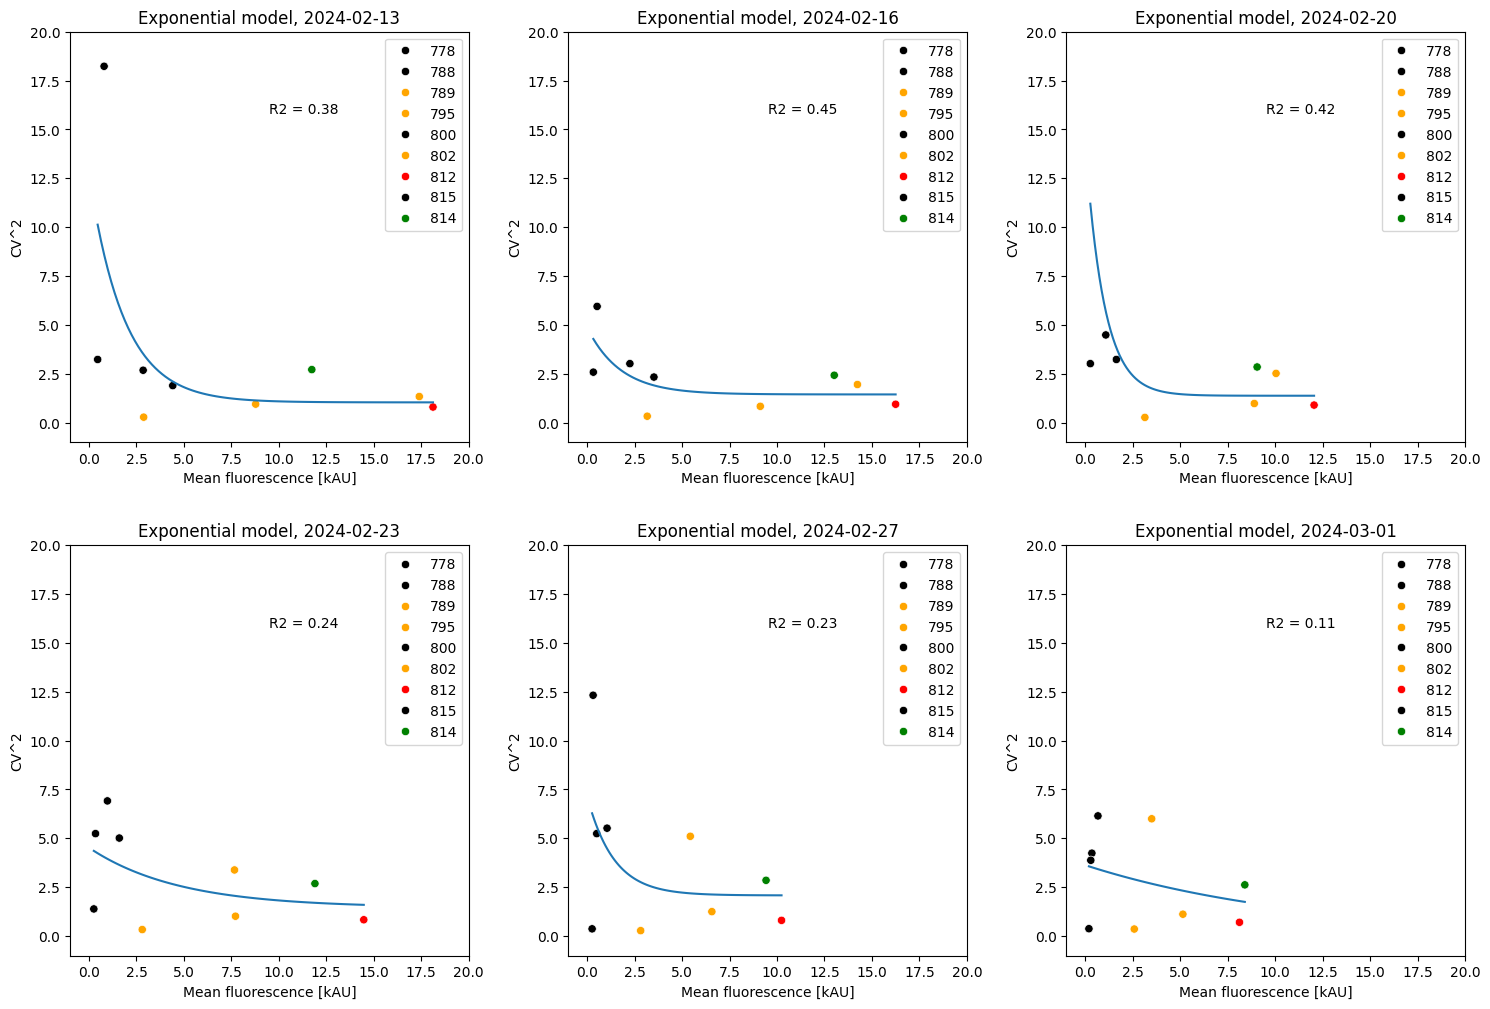

In [16]:
PCR_args_template = {
    "data": PCR_df,
    "x": "Mean.live_scaled",
    "y": "CV2.live",
    "key": None,
    "level": "Date",
    "func_dict": func_dict,
    "model": "exponential",
    "legend": "Clone",
    "ax_lims": ((-1, 20), (-1, 20)),
    "title": None,
    "x_label": "Mean fluorescence [kAU]",
    "y_label": "CV^2",
    "palette": CLONE_BY_GROUP_COLORS,
}
dates = PCR_df.index.levels[1].unique()
PCR_by_date_args = []
for i, date in enumerate(dates):
    PCR_by_date_args.append(PCR_args_template.copy())
    PCR_by_date_args[i]["key"] = date
    PCR_by_date_args[i]["title"] = f"Exponential model, {date}"

draw_multiplot_grid(
    2, 3, PCR_by_date_args, save_path="output/facs_curve_fit/figs6a-f.svg"
)

12. Fit model to results from timepoints parallel with PCR, with clones grouped as in Fig 4C. (Fig. S6G).

In [17]:
# Group clones by model
PCR_df["Model"] = PCR_df.index.get_level_values("Clone").map(
    source_df["Model"].groupby("Clone").first()
)

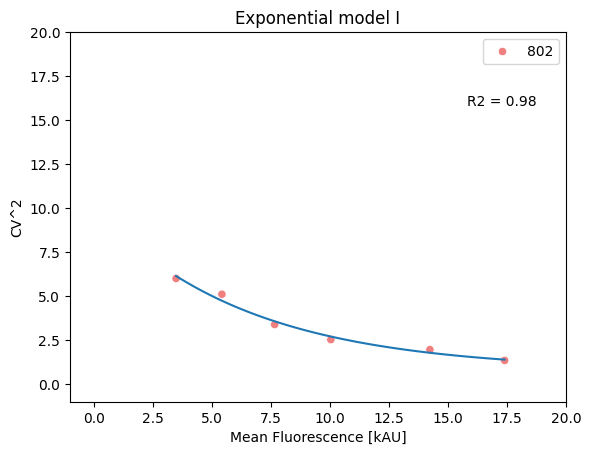

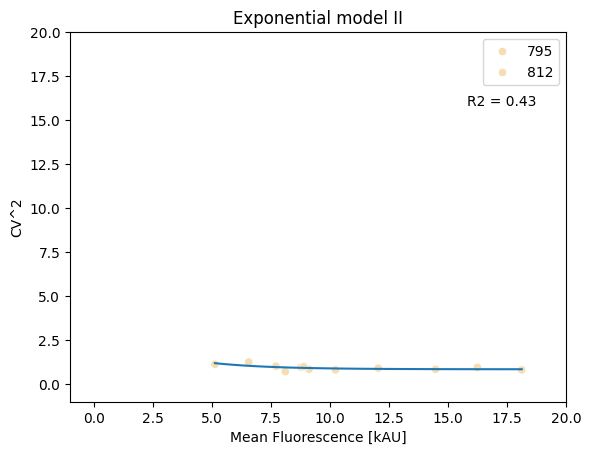

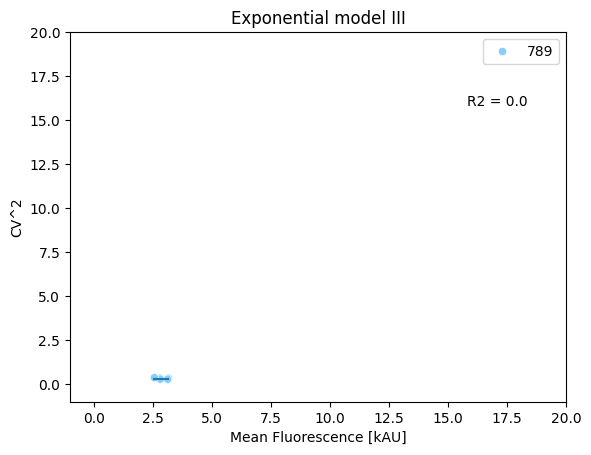

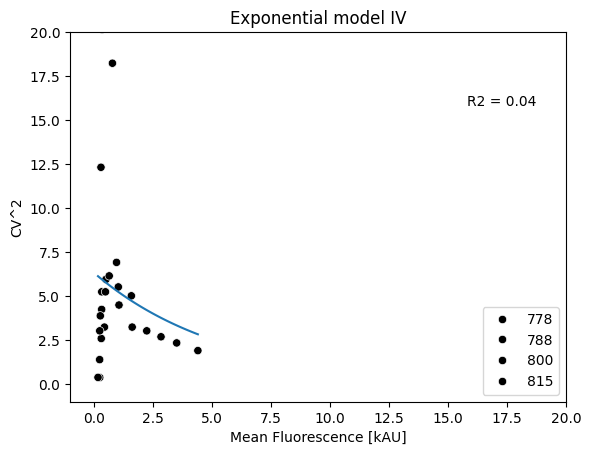

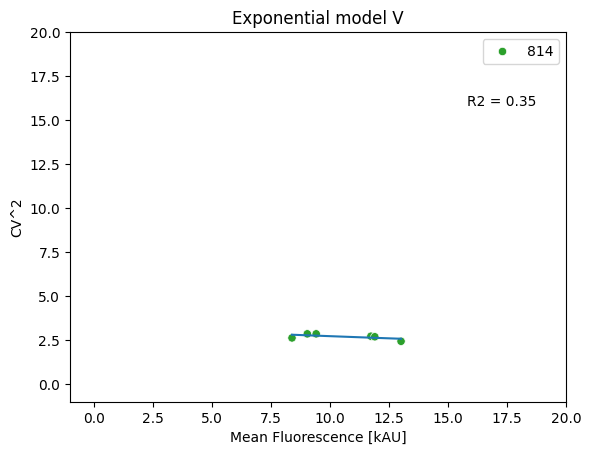

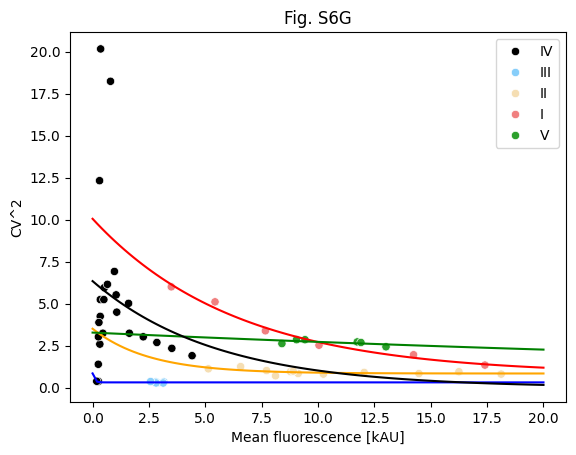

In [18]:
results_s6g = {"params": [], "err": [], "cv": [], "r2": []}
models = ["I", "II", "III", "IV", "V"]

for model in models:
    if not pathlib.Path(f"output/facs_curve_fit/exponential/").exists():
        os.makedirs(f"output/facs_curve_fit/exponential/")
    popt, perr, pcv, r2 = draw_plot_with_fit(
        PCR_df[PCR_df["Model"] == model],
        "Mean.live_scaled",
        "CV2.live",
        key="all",
        level=None,
        func_dict=func_dict,
        model="exponential",
        name=f"figs6g_model{model}",
        legend="Clone",
        title=f"Exponential model {model}",
        x_label="Mean Fluorescence [kAU]",
        y_label="CV^2",
        ax_lims=((-1, 20), (-1, 20)),
        palette=CLONE_BY_MODEL_COLORS,
    )
    results_s6g["params"].append(popt)
    results_s6g["err"].append(perr)
    results_s6g["cv"].append(pcv)
    results_s6g["r2"].append(r2)

# Create a DataFrame
model_params_df = pd.DataFrame(
    {
        "A": [p[0] for p in results_s6g["params"]],
        "B": [p[1] for p in results_s6g["params"]],
        "C": [p[2] for p in results_s6g["params"]],
        "A_err": [e[0] for e in results_s6g["err"]],
        "B_err": [e[1] for e in results_s6g["err"]],
        "C_err": [e[2] for e in results_s6g["err"]],
        "R-squared": [r for r in results_s6g["r2"]],
    },
    index=models,
)

# Round all values to 3 decimal places for better readability
model_params_df = model_params_df.round(3)
model_params_df.to_csv("output/facs_curve_fit/figs6g.csv")

# Plot a comparison of models
fig, ax = plt.subplots()
fitx = np.linspace(0, 20, 100)
fity_main = [func_dict["exponential"][0](x, *results_s6g["params"][1]) for x in fitx]
fity_high = [func_dict["exponential"][0](x, *results_s6g["params"][0]) for x in fitx]
fity_low = [func_dict["exponential"][0](x, *results_s6g["params"][2]) for x in fitx]
fity_F = [func_dict["exponential"][0](x, *results_s6g["params"][4]) for x in fitx]
fity_S = [func_dict["exponential"][0](x, *results_s6g["params"][3]) for x in fitx]
sns.scatterplot(
    data=PCR_df, x="Mean.live_scaled", y="CV2.live", hue="Model", palette=MODEL_COLORS
)
sns.lineplot(x=fitx, y=fity_main, color="orange")
sns.lineplot(x=fitx, y=fity_high, color="red")
sns.lineplot(x=fitx, y=fity_low, color="blue")
sns.lineplot(x=fitx, y=fity_F, color="green")
sns.lineplot(x=fitx, y=fity_S, color="black")
ax.set_title("Fig. S6G")
ax.set_xlabel("Mean fluorescence [kAU]")
ax.set_ylabel("CV^2")
plt.savefig(f"output/facs_curve_fit/figs6g.svg", format="svg", dpi=300)

14. Fit model to results from PCR, with clones grouped as in Fig 4C. (Fig. 4G-J).

/tmp/ipykernel_729964/3262541564.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


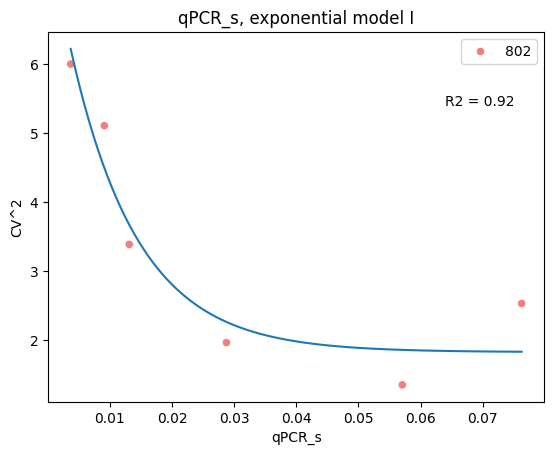

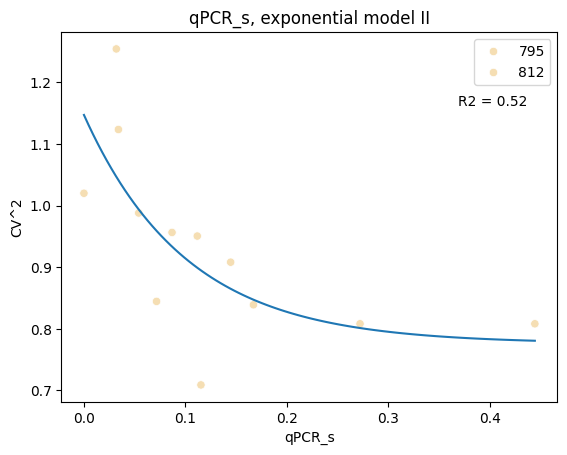

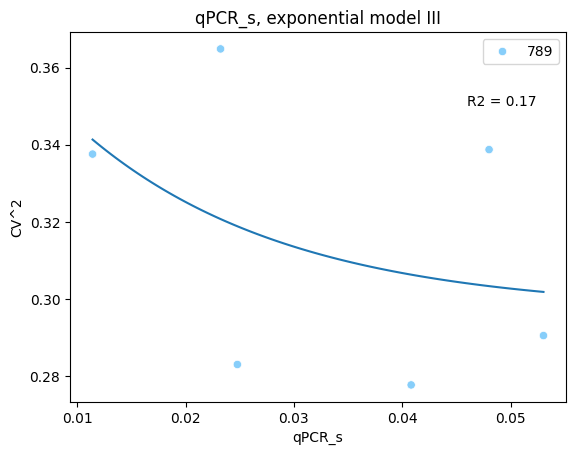

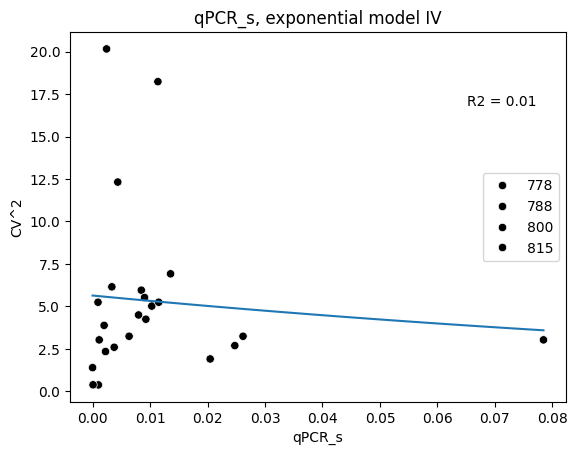

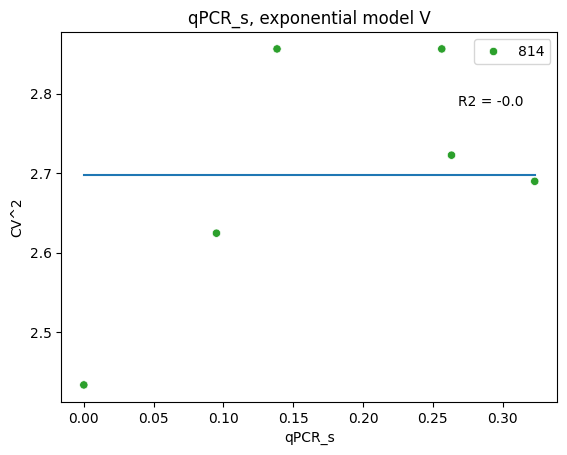

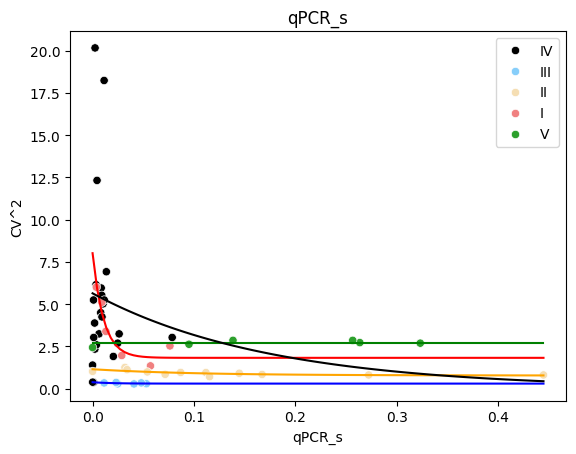

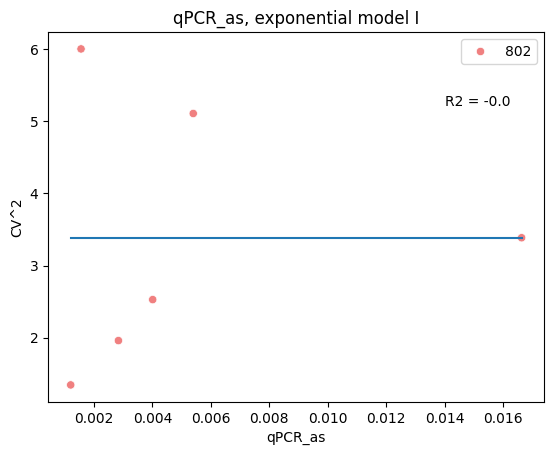

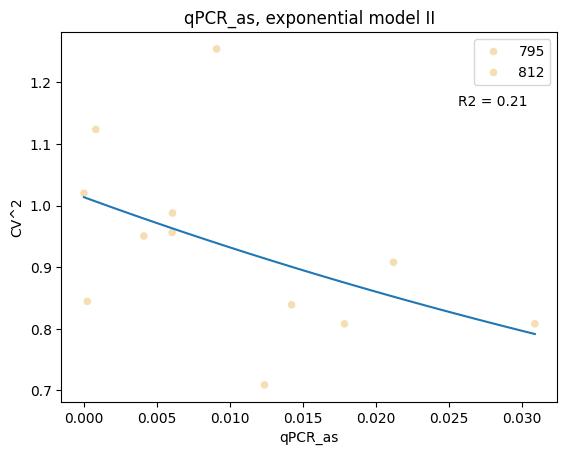

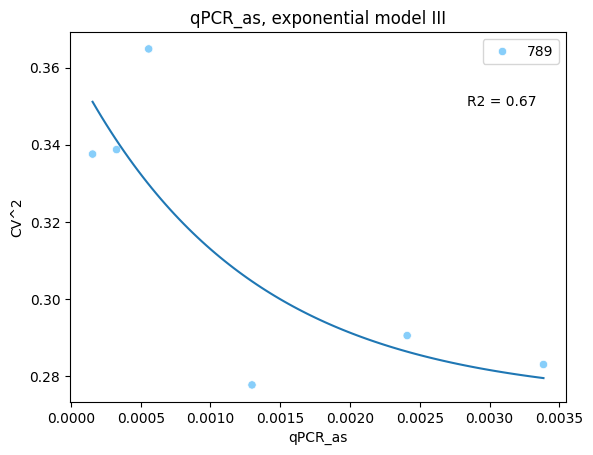

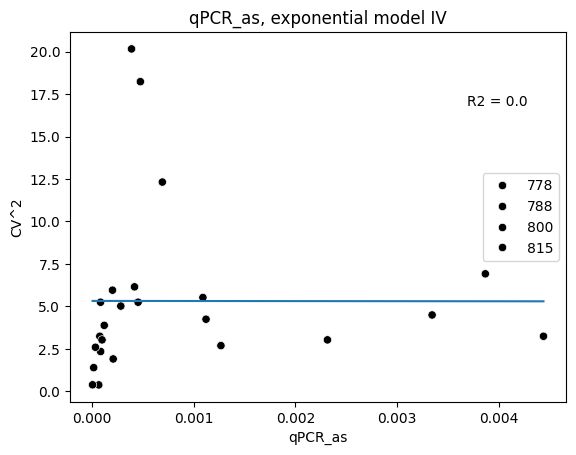

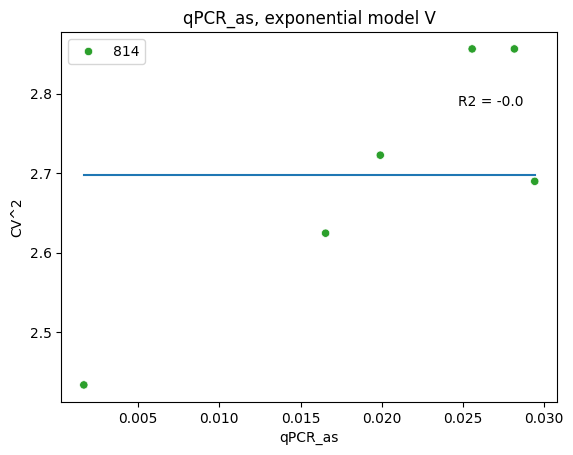

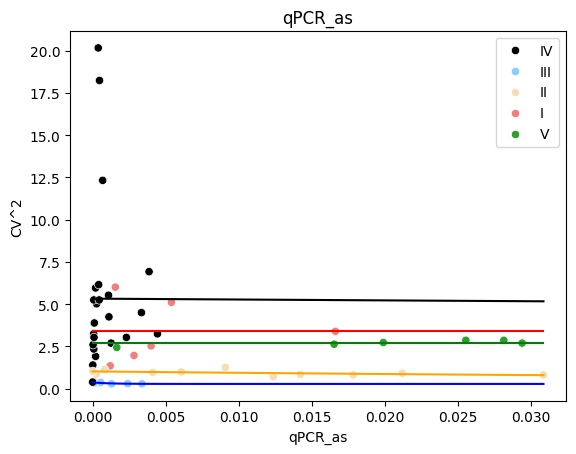

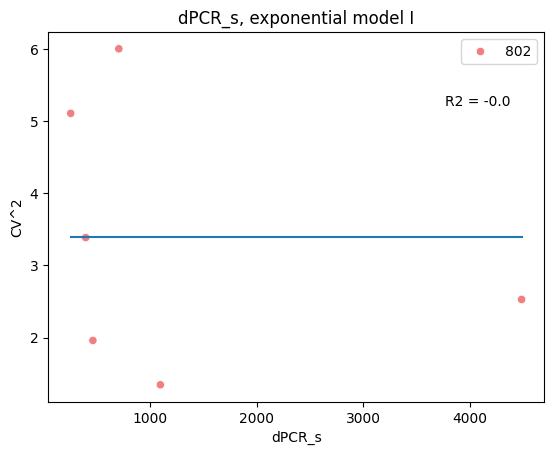

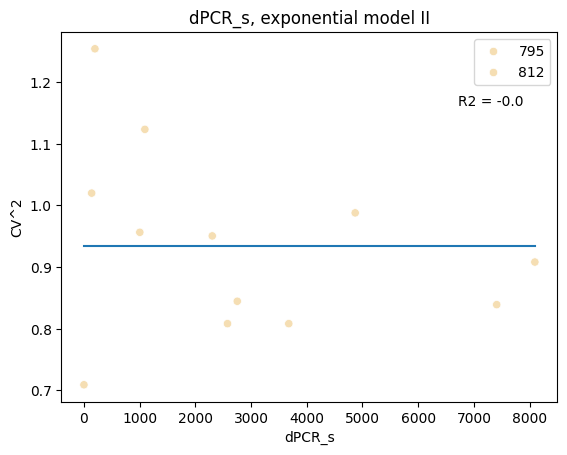

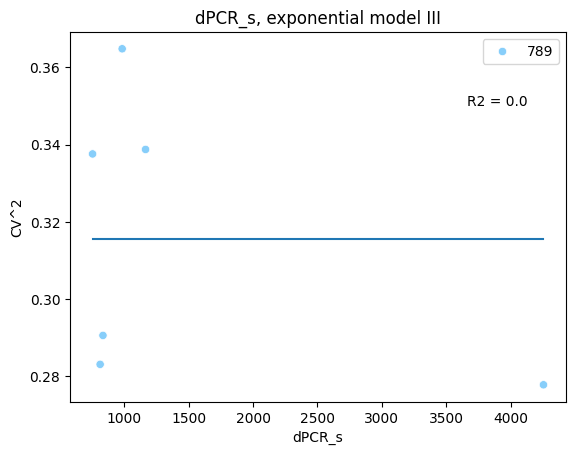

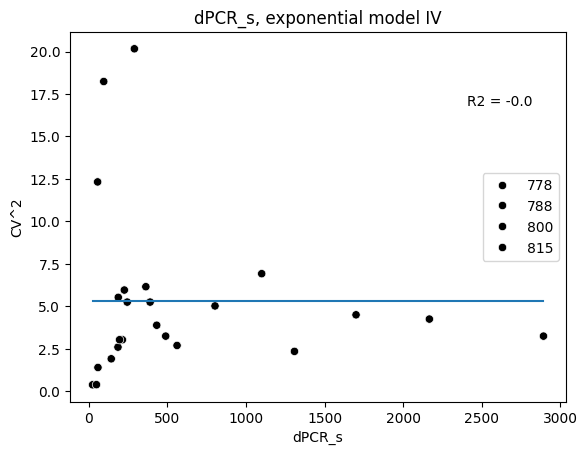

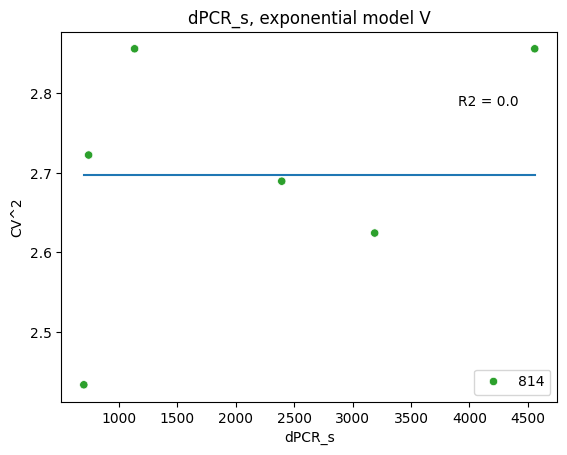

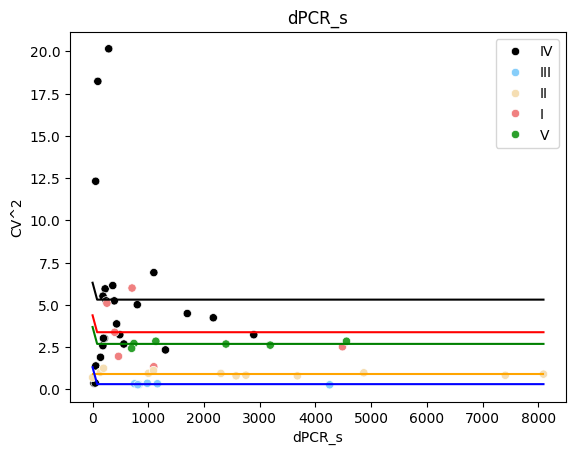

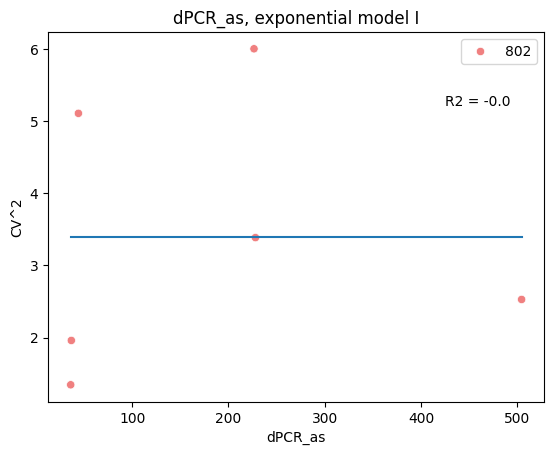

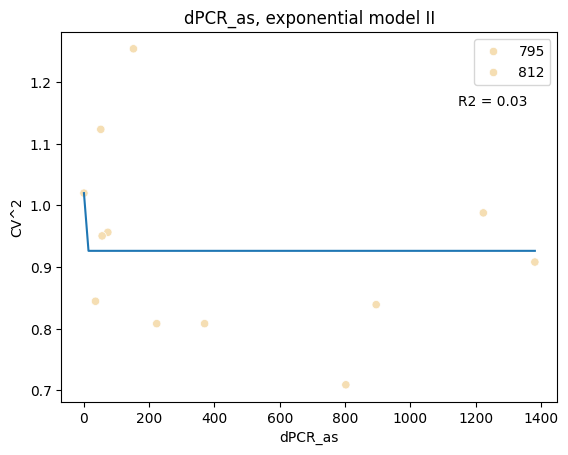

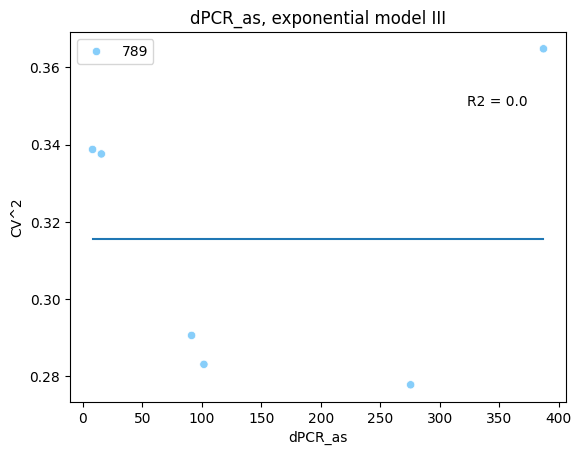

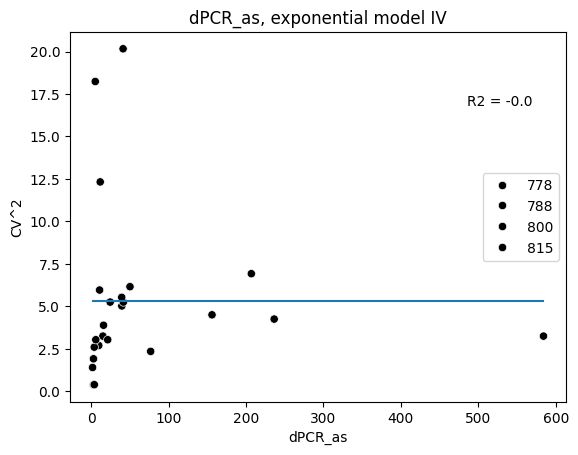

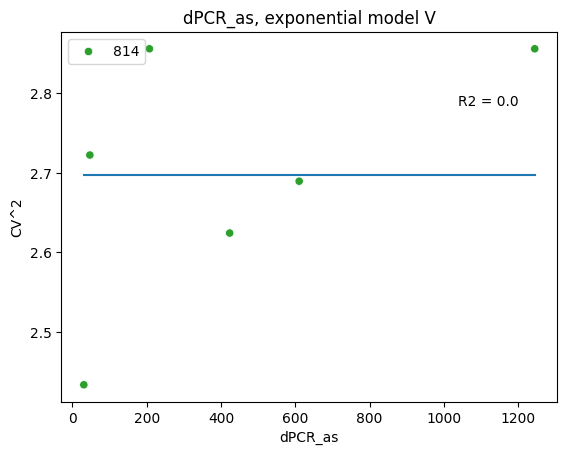

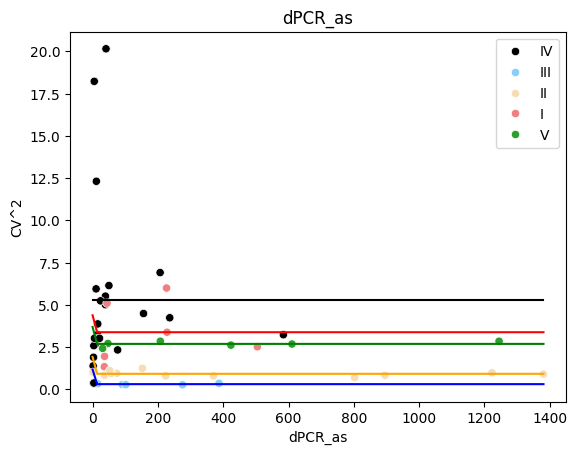

In [19]:
# Define models and PCR measurments to fit the model to
models = ["I", "II", "III", "IV", "V"]
PCR_measurments = ["qPCR_s", "qPCR_as", "dPCR_s", "dPCR_as"]
for measurment in PCR_measurments:
    # Define the results dictionary
    results = {"params": [], "err": [], "cv": [], "r2": []}

    # Fit all models
    for model in models:
        if not pathlib.Path(f"output/facs_curve_fit/exponential/").exists():
            os.makedirs(f"output/facs_curve_fit/exponential/")
        popt, perr, pcv, r2 = draw_plot_with_fit(
            PCR_df[PCR_df["Model"] == model],
            measurment,
            "CV2.live",
            key="all",
            level=None,
            func_dict=func_dict,
            model="exponential",
            name=f"{measurment}_model{model}",
            legend="Clone",
            title=f"{measurment}, exponential model {model}",
            x_label=measurment,
            y_label="CV^2",
            palette=CLONE_BY_MODEL_COLORS,
        )
        results["params"].append(popt)
        results["err"].append(perr)
        results["cv"].append(pcv)
        results["r2"].append(r2)

    # Create a DataFrame with results
    model_params_df = pd.DataFrame(
        {
            "A": [p[0] for p in results["params"]],
            "B": [p[1] for p in results["params"]],
            "C": [p[2] for p in results["params"]],
            "A_err": [e[0] for e in results["err"]],
            "B_err": [e[1] for e in results["err"]],
            "C_err": [e[2] for e in results["err"]],
            "R-squared": [r for r in results["r2"]],
        },
        index=models,
    )

    # Round all values to 3 decimal places for better readability and save dataframe
    model_params_df = model_params_df.round(3)
    model_params_df.to_csv(f"output/facs_curve_fit/{measurment}_models.csv")

    # Plot a comparison of models
    fig, ax = plt.subplots()
    max_x = PCR_df[measurment].max()
    fitx = np.linspace(0, max_x, 100)
    fity_main = [func_dict["exponential"][0](x, *results["params"][1]) for x in fitx]
    fity_high = [func_dict["exponential"][0](x, *results["params"][0]) for x in fitx]
    fity_low = [func_dict["exponential"][0](x, *results["params"][2]) for x in fitx]
    fity_F = [func_dict["exponential"][0](x, *results["params"][4]) for x in fitx]
    fity_S = [func_dict["exponential"][0](x, *results["params"][3]) for x in fitx]
    sns.scatterplot(
        data=PCR_df, x=f"{measurment}", y="CV2.live", hue="Model", palette=MODEL_COLORS
    )
    sns.lineplot(x=fitx, y=fity_main, color="orange")
    sns.lineplot(x=fitx, y=fity_high, color="red")
    sns.lineplot(x=fitx, y=fity_low, color="blue")
    sns.lineplot(x=fitx, y=fity_F, color="green")
    sns.lineplot(x=fitx, y=fity_S, color="black")
    ax.set_title(measurment)
    ax.set_xlabel(measurment)
    ax.set_ylabel("CV^2")
    plt.savefig(f"output/facs_curve_fit/{measurment}_models.svg", format="svg", dpi=300)